In [12]:
!pip install langchain_core langchain-anthropic langgraph==0.0.18 langgraph_supervisor==0.0.5

  Obtaining dependency information for langgraph==0.0.18 from https://files.pythonhosted.org/packages/41/d9/9387561737c4492c3cef2fdb3a36795ba5ceae8260ca2c98e876eb82f398/langgraph-0.0.18-py3-none-any.whl.metadata


ERROR: Could not find a version that satisfies the requirement langgraph_supervisor==0.0.5 (from versions: 0.0.1, 0.0.2, 0.0.3, 0.0.4, 0.0.6, 0.0.7, 0.0.8, 0.0.9, 0.0.10, 0.0.11, 0.0.12, 0.0.13, 0.0.14, 0.0.15, 0.0.16)
ERROR: No matching distribution found for langgraph_supervisor==0.0.5


In [13]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

ANTHROPIC_API_KEY:  ········


## Basic Building Block - Augmented LLM

In [5]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [6]:
## Schema for Structure Output
from pydantic import BaseModel, Field
class SearchQuery(BaseModel):
    search_query: str = Field(None, description= "Query that is optimized for web search")
    justification: str = Field(None, description = "Why is this query relevant to user's request")

## Augmented LLM
structured_llm =  llm.with_structured_output(SearchQuery)

## Invoke the LLM
output = structured_llm.invoke("If a dataset has correlation between its independent variables, what should be done?")
print(f"Generated Search Query -> {output.search_query}")
print(f"Justification for the same -> {output.justification}")

Generated Search Query -> how to handle multicollinearity correlation between independent variables in dataset
Justification for the same -> This search query will help find methods and solutions for dealing with correlated independent variables (multicollinearity) in a dataset, which is a common statistical problem that needs to be addressed for accurate analysis.


### Similar example with a tool

In [8]:
# define a tool
def multiply(a: int,b: int) -> int:
    return a*b
    
#Augment with tools
llm_with_tools = llm.bind_tools([multiply])

#Invoke the llm that may invoke tool call
msg = llm_with_tools.invoke("What is 5 times 6")

#tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 5, 'b': 6},
  'id': 'toolu_01YWUBBTtYtXH5zn1gTu1vMm',
  'type': 'tool_call'}]

## 1 - PROMPT CHAINING

In [11]:
from typing_extensions import TypedDict

#Graph State
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [21]:
#Nodes
def generate_joke(state: State):
    msg = llm.invoke(f"Write a short joke about: {state['topic']}")
    return {"joke":msg.content}

def improve_joke(state: State):
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke":msg.content}

def polish_joke(state: State):
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke":msg.content}

def check_punchline(state: State):
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

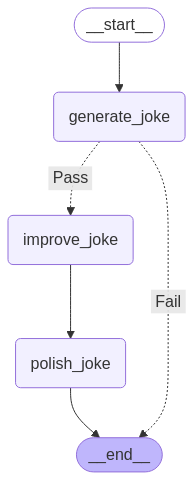

In [23]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

#Build Workflow
workflow = StateGraph(State)

# Add Nodes
workflow.add_node("generate_joke",generate_joke)
workflow.add_node("improve_joke",improve_joke)
workflow.add_node("polish_joke",polish_joke)

# Add Edges
workflow.add_edge(START,"generate_joke")
workflow.add_conditional_edges("generate_joke",check_punchline,{"Pass":"improve_joke","Fail":END})
workflow.add_edge("improve_joke","polish_joke")
workflow.add_edge("polish_joke",END)

#Compile
chain = workflow.compile()

#show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [27]:
state = chain.invoke({"topic":"cats"})
print("Initial Joke: ")
print(state["joke"])
print("\n ------------------ \n")
if("improved_joke" in state):
    print("Improved Joke: ",state["improved_joke"])
    print("Final Joke: ",state["final_joke"])
else:
    print("Joke failed quality gate. Lmao ded")    

Initial Joke: 
Here's a short cat joke:

Why don't cats like online shopping?

They prefer a cat-alog!

 ------------------ 

Improved Joke:  Here's the joke with added wordplay:

Why don't cats like online shopping?

They prefer a cat-alog! The internet just isn't their purr-furred method, and they think digital shopping is a cat-astrophe. Plus, they can't help but paws when they see a good meow-gazine!

The added puns (purr-furred, cat-astrophe, paws/pause, meow-gazine) build on the original cat-alog wordplay while keeping the same theme of shopping and cats.
Final Joke:  Here's the joke with a surprising twist:

Why don't cats like online shopping?

They prefer a cat-alog! The internet just isn't their purr-furred method, and they think digital shopping is a cat-astrophe. Plus, they can't help but paws when they see a good meow-gazine!

...But the real reason? They got scammed by a doggy website claiming to sell premium catnip! Now they're convinced the whole internet is run by cani

## 2 - Parallelization

In [48]:
from typing_extensions import TypedDict

#Graph State
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [62]:
#Nodes
def call_llm_1(state: State):
    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke":msg.content}

def call_llm_2(state: State):
    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story":msg.content}

def call_llm_3(state: State):
    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem":msg.content}

def aggregator(state: State):
    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}\n\n"
    return {"combined_output":combined}

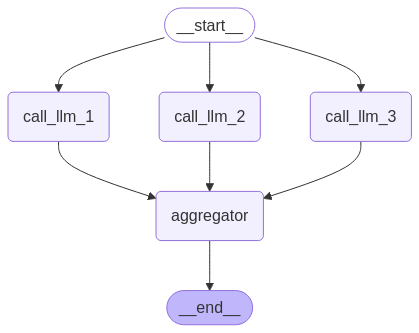

In [64]:
parallel_builder = StateGraph(State)

#AddNodes
parallel_builder.add_node("call_llm_1",call_llm_1)
parallel_builder.add_node("call_llm_2",call_llm_2)
parallel_builder.add_node("call_llm_3",call_llm_3)
parallel_builder.add_node("aggregator",aggregator)

#AddEdges
parallel_builder.add_edge(START,"call_llm_1")
parallel_builder.add_edge(START,"call_llm_2")
parallel_builder.add_edge(START,"call_llm_3")
parallel_builder.add_edge("call_llm_1","aggregator")
parallel_builder.add_edge("call_llm_2","aggregator")
parallel_builder.add_edge("call_llm_3","aggregator")
parallel_builder.add_edge("aggregator",END)
parallel_workflow = parallel_builder.compile()

# Show Workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [66]:
state = parallel_workflow.invoke({"topic":"cats"})
print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
Here's a story about cats:

The Unlikely Friendship

Luna was a sleek black cat who lived in a cozy house at the end of Maple Street. She spent most of her days lounging in sunny windowsills and watching the world outside with her bright yellow eyes. Luna had everything she could want – comfortable cushions, plenty of toys, and a loving family – but she often felt lonely during the day when her humans were away at work.

One morning, while performing her daily window watch, she noticed a scruffy orange tabby cat cautiously making his way through her garden. Unlike her well-groomed appearance, this cat's fur was slightly matted, and he had a small nick in his ear. Luna's first instinct was to hiss at the intruder, as most cats would do.

However, something about the orange cat's gentle demeanor made her pause. He stopped to smell her favorite flowers – the purple petunias – just as she often did. When he noticed her watching from the wi

## 3 - Routing

In [73]:
from typing_extensions import Literal

# Schema for structured Output to use as routing logic 
class Route(BaseModel):
    step: Literal["poem","story","joke"] = Field(None, description="The next step in routing process")

# Augmenting LLM with schema for structured Output
router = llm.with_structured_output(Route)

In [99]:
from langchain_core.messages import HumanMessage, SystemMessage

# State
class State(TypedDict):
    input: str
    decision: str
    output: str

def llm_call_1(state: State):
    """Write a poem"""
    print("********Poem Tool**********")
    result = llm.invoke(state["input"])
    return {"output":result.content}

def llm_call_2(state: State):
    """Write a joke"""
    print("********Joke Tool**********")
    result = llm.invoke(state["input"])
    return {"output":result.content}

def llm_call_3(state: State):
    """Write a story"""
    result = llm.invoke(state["input"])
    return {"output":result.content}

def llm_call_router(state: State):
    """Route the input to appropriate node"""
    decision = router.invoke(
        [
            SystemMessage(
                content = "Route the input to story, joke or poem based on the user's request."
            ),
            
            HumanMessage(content=state["input"]),
        ]
    )
    return {"decision":decision.step}

# Conditional edge function
def route_decision(state: State):
    if state["decision"] == "story":
        return "llm_call_3"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_1"

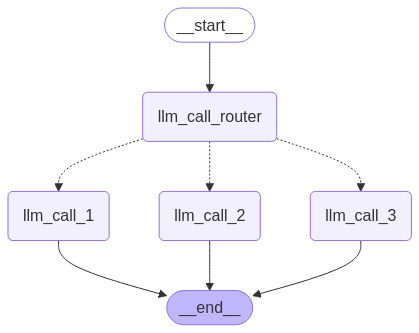

In [101]:
# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [103]:
state = router_workflow.invoke({"input": "Tell me something funny about cats"})
print(state["output"])

********Joke Tool**********
Here's a funny fact about cats: They have a hilarious "gravity-testing" behavior where they deliberately push things off elevated surfaces like tables, shelves, or countertops while maintaining direct eye contact with their owners. Scientists believe they do this partly out of curiosity and partly for attention, but many cat owners joke that cats just enjoy being tiny agents of chaos. It's even funnier because they often look completely innocent and puzzled after causing the mayhem, as if to say "How did that happen? Surely it wasn't me!"


In [105]:
state = router_workflow.invoke({"input": "Describe cats poetically"})
print(state["output"])

********Poem Tool**********
Here's a poetic description of cats:

Velvet-footed shadows glide,
Moonlit whispers, amber eyes,
Grace embodied, lithe and fair,
Midnight dancers without care.

Masters of the twilight hour,
Wrapped in fur of royal power,
Silent hunters, proud and keen,
Moving like a mystic dream.

Liquid spine and satin paw,
Nature's perfect work of art,
Ancient wisdom in their gaze,
Sphinx-like watchers of our days.

Purring sonnets soft and low,
Independent spirits flow,
Half-wild souls in gentle guise,
Keepers of sweet mysteries.

Subtle rulers of our homes,
Bearing secrets all their own,
Regal in their quiet way,
Dancing through both night and day.

Tender when they choose to be,
Wild when stretching to be free,
Poetry in motion made,
In each graceful feline blade.


## 4 - ORCHESTRATOR WORKER

In [111]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

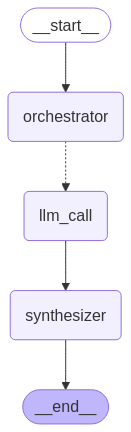

In [119]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""
    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )
    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""
    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )
    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""
    # List of completed sections
    completed_sections = state["completed_sections"]
    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""
    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [121]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

In [122]:
state["sections"]

[Section(name='Introduction to LLM Scaling Laws', description='Overview of what scaling laws are in the context of Large Language Models, their importance in AI research, and historical background of key scaling studies.'),
 Section(name='Fundamental Scaling Relationships', description='Detailed examination of core scaling laws including compute-optimal scaling, parameter scaling, dataset scaling, and their mathematical foundations as established by seminal papers like Kaplan et al.'),
 Section(name='Empirical Evidence and Major Studies', description='Analysis of key experimental studies that validate scaling laws, including results from OpenAI, DeepMind, and other research institutions, with actual performance measurements and trends.'),
 Section(name='Scaling Limitations and Challenges', description='Discussion of practical constraints in scaling LLMs, including computational resources, energy requirements, data quality issues, and potential diminishing returns.'),
 Section(name='Eco

In [125]:
from IPython.display import Markdown
Markdown(state["final_report"])

## Introduction to LLM Scaling Laws

Scaling laws describe systematic relationships between a language model's performance and key variables like model size, dataset size, and compute resources. These mathematical patterns show how model capabilities improve as these factors increase, typically following power law relationships.

Key aspects of LLM scaling laws include:

- **Model Size**: Performance improves smoothly with increased parameter count
- **Training Data**: Larger datasets enable better performance, with diminishing returns
- **Compute**: Training compute requirements grow with model size and data volume
- **Loss Curves**: Training and test loss follow predictable power law curves

Historical development of scaling research:

- 2018: OpenAI's initial work on transformer scaling behavior
- 2020: Kaplan et al. published seminal "Scaling Laws for Neural Language Models"
- 2022: Chinchilla paper revised optimal compute allocation theories
- 2023: Scaling studies extended to instruction-tuned and multimodal models

Practical implications:

- Guides efficient resource allocation for training
- Enables performance prediction for larger models
- Informs hardware and infrastructure requirements
- Helps optimize model architecture decisions

Limitations and open questions:

- Unclear applicability to emergent capabilities
- Potential deviation at extreme scales
- Environmental and computational constraints
- Need for new scaling laws for specialized architectures

---

## Fundamental Scaling Relationships

### Compute-Optimal Scaling

- Empirically validated relationship between compute budget (C) and optimal model size (N):
  - N ∝ C^(0.73)
  - Holds across multiple orders of magnitude of compute
  - First established in Kaplan et al. (2020)

### Parameter Scaling

- Model performance improves predictably with parameter count:
  - Loss = α(N^(-0.076)), where N is number of parameters
  - Diminishing returns follow power law relationship
- Critical parameter thresholds identified:
  - Emergence of capabilities at specific scale points
  - Smooth scaling between capability jumps

### Dataset Scaling

- Training dataset size (D) scales with model parameters:
  - Optimal D ∝ N^(0.74)
  - Insufficient data leads to premature saturation
  - Excess data wastes compute without benefit

### Mathematical Foundations

- Power law relationships dominate scaling behavior:
  - Loss = α(C^(-0.050)) for compute
  - Loss = α(D^(-0.095)) for dataset size
- Scaling coefficients remain consistent across:
  - Model architectures
  - Training objectives
  - Domain applications

### Interdependent Scaling Factors

- Optimal scaling requires balanced growth across:
  - Model parameters
  - Dataset size
  - Compute budget
  - Training steps
- Sub-optimal allocation reduces efficiency:
  - Bottlenecks from any single factor
  - Waste from oversized resources

### Practical Implications

- Guides resource allocation for training
- Enables accurate performance prediction
- Informs hardware requirements
- Supports cost-benefit analysis
- Helps identify efficiency opportunities

### Limitations and Constraints

- Economic constraints on compute growth
- Dataset quality versus quantity tradeoffs
- Architecture-specific deviations
- Emergence of new scaling regimes at extreme scale

---

## Empirical Evidence and Major Studies

Several landmark studies have provided strong empirical validation of neural network scaling laws:

### OpenAI's Language Model Studies
- Demonstrated consistent power-law relationships between model size and performance
- GPT-3 (175B parameters) empirically validated predictions about loss scaling
- Found that loss decreases smoothly as compute and dataset size increase
- Identified optimal model size scales with available compute as: N ∝ C^(0.7-0.8)

### Anthropic's Parameter Scaling Research
- Investigated scaling behavior across 100+ language models
- Confirmed performance follows power law: Loss ∝ N^(-0.076)
- Discovered diminishing returns begin around 10^23 FLOPs
- Validated cross-entropy loss predictions across multiple architectures

### DeepMind's Scaling Studies
- Chinchilla (70B parameters) demonstrated optimal parameter/data balance
- Found many models were overparameterized relative to training data
- Established relationship: Optimal parameter count ∝ Training tokens
- Showed compute-optimal training uses equal compute for parameters and data

### Google's Pathway Language Model Research
- PaLM (540B parameters) confirmed predicted scaling benefits
- Demonstrated consistent improvements across 540+ tasks
- Validated transfer learning advantages of larger models
- Showed enhanced performance on reasoning and mathematics

### Key Performance Measurements
- Pre-training loss reduction: 2.1-2.5x per 10x parameter increase
- Downstream task improvements: 1.5-2x per 10x compute increase 
- Consistent scaling across model architectures (Transformers, MLP-Mixers)
- Lower bounds on model size needed for specific capabilities

### Limitations and Caveats
- Scaling laws break down at computational extremes
- Architecture-specific variations in exact scaling coefficients
- Environmental/computational costs of validation at scale
- Difficulty measuring sparse model performance

These empirical results have been instrumental in guiding model development and validating theoretical predictions about neural network scaling behavior.

---

## Scaling Limitations and Challenges

### Computational Resources
- Training modern LLMs requires massive computing infrastructure
- High-end GPUs/TPUs cost millions of dollars
- Limited availability of specialized AI hardware
- Memory constraints for model parameters and training data
- Complex distributed computing requirements for large-scale training

### Energy Requirements
- Training large models consumes substantial electricity
- GPT-3 training estimated at 1,287 MWh (equivalent to 120+ US homes' annual usage)
- Environmental concerns regarding carbon footprint
- Cooling requirements for data centers add additional energy overhead
- Inference costs scale with model deployment and usage

### Data Quality Issues
- High-quality training data becoming scarcer
- Increased presence of synthetic/AI-generated content online
- Data cleaning and filtering costs rising
- Language coverage gaps for non-English content
- Challenges with data privacy and licensing
- Risk of training on biased or inappropriate content

### Diminishing Returns
- Empirical evidence suggests sublinear scaling of capabilities
- Doubling parameters yields smaller improvements over time
- Cost-to-benefit ratio becoming less favorable
- Architectural innovations may be needed over pure scaling
- Limited gains in reasoning and knowledge beyond certain scale
- Potential fundamental limits to current architectural approaches

### Infrastructure Bottlenecks  
- Network bandwidth constraints for distributed training
- Storage requirements for checkpoints and training data
- Engineering complexity of maintaining large clusters
- Limited pool of experts capable of training large models
- High operational costs for extended training runs

---

## Economic and Infrastructure Implications

### Training Costs
- Pre-training costs for large language models range from millions to hundreds of millions of dollars
- GPT-3 175B estimated training cost: $4.6M-$12M
- Costs scale approximately linearly with model size
- Significant electricity consumption during training: 1,287 MWh for GPT-3

### Hardware Requirements
- Specialized GPU/TPU clusters needed for training
- Memory requirements increase with model size:
  - 3B parameter model: ~6GB GPU memory
  - 175B parameter model: ~350GB GPU memory
- High-bandwidth interconnects required between compute nodes
- Significant cooling infrastructure needed for large clusters

### Infrastructure Needs
- Distributed computing systems essential for large models
- Data center specifications:
  - High-power density racks (15-30 kW per rack)
  - Redundant power supplies
  - Advanced cooling systems
  - High-speed networking (400Gbps+ interconnects)

### Operational Considerations
- Continuous maintenance and hardware replacement costs
- System redundancy requirements
- Network bandwidth for model deployment
- Storage infrastructure for training data and checkpoints

### Cost Optimization Strategies
- Mixed precision training
- Model parallelism
- Efficient architecture designs
- Cloud vs. on-premises infrastructure tradeoffs
- Resource sharing and scheduling optimization

### Environmental Impact
- Carbon footprint of training large models
- Energy efficiency considerations
- Sustainable computing practices
- Green energy sourcing opportunities

---

## Future Directions and Alternative Approaches

### Alternative Architectures
- Sparse neural networks that selectively activate only relevant pathways
- Mixture-of-experts architectures distributing computation across specialized sub-networks
- Neural circuit-inspired architectures incorporating biological principles
- Hybrid architectures combining different model types (transformers, CNNs, RNNs)

### Emerging Scaling Approaches
- Parameter-efficient fine-tuning methods (LoRA, prefix tuning)
- Model compression and pruning techniques
- Knowledge distillation to create smaller, specialized models
- Conditional computation to dynamically allocate resources

### Novel Training Methods
- Few-shot and zero-shot learning to reduce data requirements
- Continual learning approaches to incrementally update models
- Meta-learning techniques for faster adaptation
- Self-supervised and semi-supervised learning strategies

### Hardware-Aware Optimization
- Custom neural processing units (NPUs)
- Analog and photonic computing
- Neuromorphic hardware designs
- Edge computing optimization

### Beyond Pure Scale
- Multi-modal reasoning capabilities
- Improved architectural inductive biases
- Enhanced interpretability and control
- Integration of symbolic and neural approaches

### Quality-Focused Development
- Better evaluation metrics beyond scale
- Robustness and reliability improvements
- Reduced environmental impact
- Enhanced safety and alignment methods

---

## Conclusion and Industry Impact

- Scaling laws demonstrate predictable relationships between model performance, compute resources, and dataset size, enabling strategic planning for AI development

- Key findings show that model capabilities follow power-law scaling patterns, with diminishing returns at extreme scales

- Industry implications:
  - Resource allocation optimization between model size, training data, and compute
  - Better cost-benefit analysis for training large models
  - Informed decision-making on infrastructure investments

- Research directions influenced by scaling laws:
  - Focus on architectural improvements to achieve better scaling efficiency
  - Emphasis on data quality and curation over raw quantity
  - Investigation of emergent capabilities at specific scale thresholds

- Practical considerations for AI companies:
  - Trade-offs between model size and deployment costs
  - Environmental impact of large-scale training
  - Competitive dynamics between small and large players

- Future outlook:
  - Continued importance of scaling in advancing AI capabilities
  - Growing emphasis on efficient scaling techniques
  - Potential for breakthrough architectures that alter current scaling patterns

## 5 - EVALUATOR OPTIMIZER

In [134]:
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )
# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [136]:
# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""
    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""
    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}
    
# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

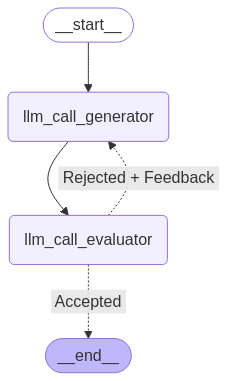

In [138]:
# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [140]:
# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

Here's a cat joke for you:

Why don't cats like online shopping?

They prefer a cat-alog!

(Get it? Catalog/cat-alog! 😺)


In [141]:
print(state["feedback"])

This is a clever play on words that works on multiple levels. It uses the word "catalog" and splits it into "cat-alog" to create a pun that's relevant to cats. The setup also makes sense because it references modern online shopping contrasted with traditional catalogs. The emoji adds a cute touch that enhances the cat theme. It's a clean, family-friendly joke that's both witty and accessible.


In [144]:
print(state["funny_or_not"])

funny


## 6 - Finally,  AGENTS!!

In [149]:
from langchain_core.tools import tool

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [153]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""
    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


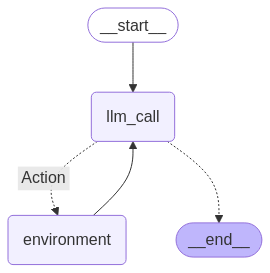

In [155]:
# Build workflow
agent_builder = StateGraph(MessagesState)
# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [159]:
# Invoke
messages = [HumanMessage(content="Add 3 and 4. Then multiply by 7")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Then multiply by 7
================================== Ai Message ==================================

[{'text': "I'll help you with that calculation. Let's break it down into steps:\n\n1. First, let's add 3 and 4:", 'type': 'text'}, {'id': 'toolu_01XL19sihAhg8YzhFS4XesEr', 'input': {'a': 3, 'b': 4}, 'name': 'add', 'type': 'tool_use'}]
Tool Calls:
  add (toolu_01XL19sihAhg8YzhFS4XesEr)
 Call ID: toolu_01XL19sihAhg8YzhFS4XesEr
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

[{'text': "2. Now, let's multiply the result (7) by 7:", 'type': 'text'}, {'id': 'toolu_01UaD5eomCv3Bqzcwbdqu7UC', 'input': {'a': 7, 'b': 7}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_01UaD5eomCv3Bqzcwbdqu7UC)
 Call ID: toolu_01UaD5eomCv3Bqzcwbdqu7UC
  Arg

# Hierarchial Multi-Agent System

### B - Agent with short-term memory
LangGraph persistence layer
Allows you to resume any conversation with the agent
@entrypoint

Decorator indicates the start of a workflow / agent
Produces a Pregel object, an abstraction for managing a few things
Execution -- Syncronous (invoke), Async (ainvoke), streaming (stream)
State -- Checkpointing, Human in the loop (interrupt)
Optional: @entrypoint.final

Can be used to specify what to return vs what to checkpoint
@task

Results from tasks are saved as checkpoints
Important for caching results (time-consuming operations)
Support streaming updates from tasks
Support tracing
Calling a task --

When you call a task, it returns immediately with a future object.
A future is a placeholder for a result that will be available later.
.result() marks where in the code you actually need the task's result.

In [17]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [19]:
from langchain_core.tools import tool

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [25]:
import uuid
from langgraph.func import entrypoint, task # New 
from langgraph.checkpoint.memory import MemorySaver # New 
from langgraph.graph import add_messages
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    BaseMessage,
    ToolCall,
)

@task # New
def call_llm(messages: list[BaseMessage]):
    """LLM decides whether to call a tool or not"""
    return llm_with_tools.invoke(
        [
            SystemMessage(
                content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
            )
        ]
        + messages
    )

@task # New
def call_tool(tool_call: ToolCall):
    """Performs the tool call"""

    tool = tools_by_name[tool_call["name"]]
    return tool.invoke(tool_call)

checkpointer = MemorySaver() # New
@entrypoint(checkpointer=checkpointer) # New 
def agent(messages: list[BaseMessage], previous: list[BaseMessage]):
    """ Tool calling agent """
    # Add previous messages from short-term memory to the current messages
    if previous is not None:
        messages = add_messages(previous, messages)    
    # Call the LLM
    llm_response = call_llm(messages).result()
    while True:
        if not llm_response.tool_calls:
            break
        # Execute tools
        tool_results = [
            call_tool(tool_call).result() for tool_call in llm_response.tool_calls
        ]
        messages = add_messages(messages, [llm_response, *tool_results])
        llm_response = call_llm(messages).result()
    messages = add_messages(messages, llm_response)

    # Return LLM response and save the full message history
    return messages

In [23]:
# Thread ID
thread_id = str(uuid.uuid4())
# Config
config = {"configurable": {"thread_id": thread_id}}
# Run with checkpointer to persist state in memory
messages = agent.invoke([HumanMessage(content="Add 3 and 4.")], config)
for m in messages:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================

[{'text': "I'll help you add 3 and 4 using the `add` function.", 'type': 'text'}, {'id': 'toolu_01SwrSZovYng8KTv37yMYRuh', 'input': {'a': 3, 'b': 4}, 'name': 'add', 'type': 'tool_use'}]
Tool Calls:
  add (toolu_01SwrSZovYng8KTv37yMYRuh)
 Call ID: toolu_01SwrSZovYng8KTv37yMYRuh
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


### C - Agent with HITL

In [34]:
from langgraph.types import interrupt

@task
def call_llm(messages: list[BaseMessage]):
    """LLM decides whether to call a tool or not"""
    print("Calling LLM!")
    return llm_with_tools.invoke(
        [
            SystemMessage(
                content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
            )
        ]
        + messages
    )

@task
def call_tool(tool_call: ToolCall):
    """Performs the tool call"""
    print("Calling tool!")
    # Interrupt the workflow to get a review from a human.
    is_approved = interrupt({ # New 
            # Any json-serializable payload provided to interrupt as argument.
            # It will be surfaced on the client side as an Interrupt when streaming data
            # from the workflow.
            "tool_call": tool_call, # The tool call we want reviewed.
            # We can add any additional information that we need.
            # For example, introduce a key called "action" with some instructions.
            "action": "Please approve/reject the tool call",
        })
    
    if is_approved:
        tool = tools_by_name[tool_call["name"]]
        return tool.invoke(tool_call)
    else:
        return "Tool call rejected"

@entrypoint(checkpointer=MemorySaver())  
def agent(messages: list[BaseMessage], previous: list[BaseMessage]): 
    """ Tool calling agent """
    print("Executing agent!")
    
    # Add previous messages from short-term memory to the current messages
    if previous is not None:
        messages = add_messages(previous, messages)
    
    # Call the LLM
    llm_response = call_llm(messages).result()

    while True:
        if not llm_response.tool_calls:
            break

        # Execute tools
        tool_results = [
            call_tool(tool_call).result() for tool_call in llm_response.tool_calls
        ]
        messages = add_messages(messages, [llm_response, *tool_results])
        llm_response = call_llm(messages).result()

    messages = add_messages(messages, llm_response)
    return messages

In [30]:
# Thread ID
thread_id = str(uuid.uuid4())

# Config
config = {"configurable": {"thread_id": thread_id}}

# Run until the interrupt 
for item in agent.stream([HumanMessage(content="Add 3 and 4.")], config, stream_mode="updates"):
    if '__interrupt__' in item:
        print(item['__interrupt__'][0].value)

Executing agent!
Calling LLM!
Calling tool!
{'tool_call': {'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'toolu_01DHaTNcKddvftJ8oPo9MJsT', 'type': 'tool_call'}, 'action': 'Please approve/reject the tool call'}
{'tool_call': {'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'toolu_01DHaTNcKddvftJ8oPo9MJsT', 'type': 'tool_call'}, 'action': 'Please approve/reject the tool call'}


In [32]:
from langgraph.types import Command
for item in agent.stream(Command(resume=True), config, stream_mode="updates"):
    if 'agent' in item:
        item['agent'][-1].pretty_print()

Executing agent!
Calling tool!
Calling LLM!
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
